<a href="https://colab.research.google.com/github/HartsaRizq/Capstone-Project-C23-PS463/blob/Machine-Learning/Clothes%20Recognition/Clothes_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import tensorflow_hub as hub
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
from google.colab import drive
!pip install rarfile
import rarfile
from google.colab import files
import keras.utils as image
from google.colab.patches import cv2_imshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(np.__version__)

1.22.4


# Download and extract the dataset

In [ ]:
# https://drive.google.com/file/d/1M5ERdRKHjR3ei0ZJkXY5Xja9zrNTkKBn/view?usp=share_link
!gdown --id 1M5ERdRKHjR3ei0ZJkXY5Xja9zrNTkKBn

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1M5ERdRKHjR3ei0ZJkXY5Xja9zrNTkKBn
To: /content/Fix_Dataset.rar
100% 156M/156M [00:02<00:00, 53.0MB/s]


In [ ]:
with rarfile.RarFile("Fix_Dataset.rar") as f:
  f.extractall("/tmp")

# Load the dataset

In [ ]:
sdir=r'/tmp/Fix_Dataset/'


filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (classlist)
print (df['labels'].value_counts())

['Gym_Jacket', 'Coat', 'Blazzer', 'Shirt (Kemeja)', 'Sweter', 'Pants', 'Jeans', 'Shorts', 'Denim_Jacket', 'Dress', 'Skirt', 'T-Shirt', 'Polo', 'Hoodie', 'Jacket']
T-Shirt           1018
Sweter             689
Shirt (Kemeja)     386
Dress              357
Shorts             310
Jeans              183
Skirt              156
Pants              134
Jacket             129
Gym_Jacket         125
Polo               120
Denim_Jacket       113
Blazzer            112
Coat               109
Hoodie             101
Name: labels, dtype: int64


# Preprocessing

In [ ]:
IMAGE_SIZE=224
BATCH_SIZE=64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
	  rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255,
     validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    sdir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    sdir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 4042 images belonging to 15 classes.
Found 397 images belonging to 15 classes.


# Make the model

In [ ]:
Classifier_Model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SIZE = (224, 224)

feature_extractor = hub.KerasLayer(Classifier_Model, input_shape=IMAGE_SIZE + (3,))

model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator)

Epoch 1/100
64/64 [==============================] - 80s 1s/step - loss: 1.9484 - accuracy: 0.4023 - val_loss: 1.1858 - val_accuracy: 0.6524
Epoch 2/100
64/64 [==============================] - 65s 1s/step - loss: 1.2653 - accuracy: 0.5970 - val_loss: 0.9462 - val_accuracy: 0.6826
Epoch 3/100
64/64 [==============================] - 65s 1s/step - loss: 1.1127 - accuracy: 0.6390 - val_loss: 0.7971 - val_accuracy: 0.7406
Epoch 4/100
64/64 [==============================] - 66s 1s/step - loss: 1.0216 - accuracy: 0.6625 - val_loss: 0.7271 - val_accuracy: 0.7708
Epoch 5/100
64/64 [==============================] - 65s 1s/step - loss: 0.9481 - accuracy: 0.6873 - val_loss: 0.6766 - val_accuracy: 0.7809
Epoch 6/100
64/64 [==============================] - 65s 1s/step - loss: 0.9098 - accuracy: 0.6982 - val_loss: 0.6133 - val_accuracy: 0.7985
Epoch 7/100
64/64 [==============================] - 65s 1s/step - loss: 0.8497 - accuracy: 0.7217 - val_loss: 0.6121 - val_accuracy: 0.7985
Epoch 8/100
6

# Accuracy

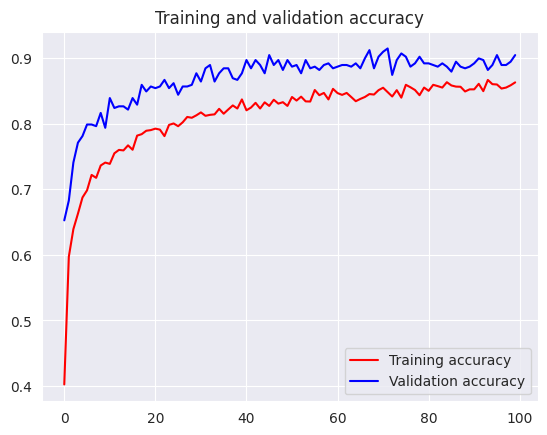

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")

Model Loss is 0.29 and Accuracy is 90.42999999999999%


# Save the model

In [ ]:
clothing_recognition = '/content/drive/My Drive/clothing-recognition.h5'

model.save(clothing_recognition, save_format="h5")

# Load the model

In [2]:
my_model = tf.keras.models.load_model(
    ('/content/drive/My Drive/clothing-recognition.h5'), custom_objects={'KerasLayer':hub.KerasLayer}
)

# Exporting to TF-Lite

In [3]:
export_dir = 'saved_model/1'

tf.saved_model.save(my_model, export_dir)

In [4]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [5]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) 

converter.optimizations = [optimization] 

tflite_model = converter.convert()

In [13]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

8941868

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

In [10]:
with open('converted_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Make Prediction

Saving 0a69db60-c052-4b9a-a90d-e53120d091d5.jpg to 0a69db60-c052-4b9a-a90d-e53120d091d5.jpg
Saving 0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg to 0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg
Saving 0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg to 0d3cf39f-78f1-440e-9504-f510e75aff0b.jpg
Saving 0d87a812-8c30-4b1f-9ecc-199ae426c8e6.jpg to 0d87a812-8c30-4b1f-9ecc-199ae426c8e6.jpg
Saving 0d639320-434a-469f-a9b7-d1f8e3b1f22a.jpg to 0d639320-434a-469f-a9b7-d1f8e3b1f22a.jpg


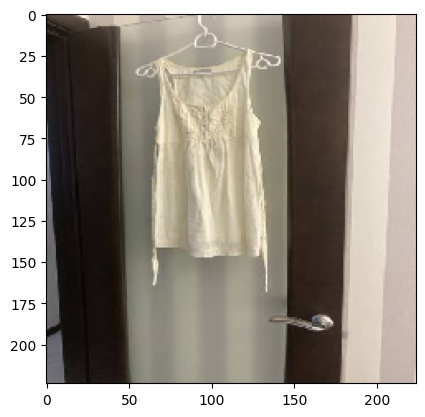

1/1 [==============================] - 0s 30ms/step
[[1.0998162e-06 4.0987483e-03 1.6475012e-08 9.0714222e-01 3.4140309e-03
  6.0039001e-05 2.9467407e-04 2.7397840e-04 1.7006928e-03 7.4157782e-05
  1.0814717e-02 7.2558632e-04 2.5383959e-02 2.3805075e-03 4.3635651e-02]]
{'Prediction': 'Dress'}


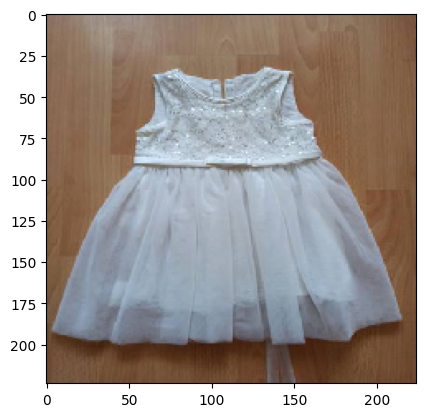

1/1 [==============================] - 0s 26ms/step
[[4.5205007e-07 7.4643418e-07 1.4274028e-05 9.9886715e-01 4.8068152e-05
  1.9486039e-05 4.9354168e-07 2.5905509e-09 9.9089137e-09 7.5032426e-06
  2.7590414e-04 4.9442735e-07 5.3884345e-04 6.8956957e-05 1.5769120e-04]]
{'Prediction': 'Dress'}


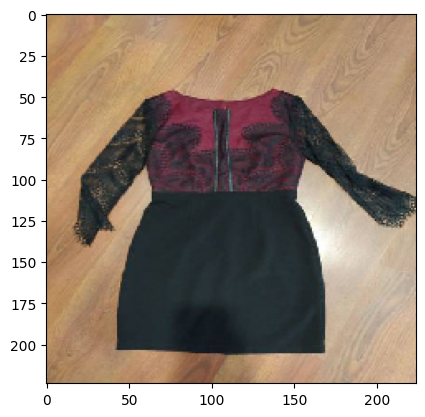

1/1 [==============================] - 0s 35ms/step
[[1.9157764e-05 4.3652256e-04 1.2099372e-03 9.9219900e-01 3.5536007e-04
  2.2986752e-03 5.5933482e-04 6.3690159e-06 2.5233827e-05 9.4807638e-07
  9.8896387e-04 2.2166711e-05 1.7053387e-04 1.6825264e-03 2.5384901e-05]]
{'Prediction': 'Dress'}


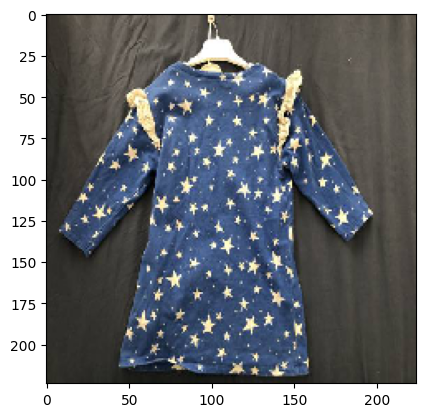

1/1 [==============================] - 0s 36ms/step
[[1.1312985e-03 6.9798087e-03 2.3555519e-02 3.7786269e-01 2.1187626e-03
  5.4201722e-04 1.0570334e-03 8.2576207e-06 1.6661402e-04 1.2506816e-01
  1.8983748e-02 3.4101609e-05 8.2277575e-06 1.2575160e-01 3.1673211e-01]]
{'Prediction': 'Dress'}


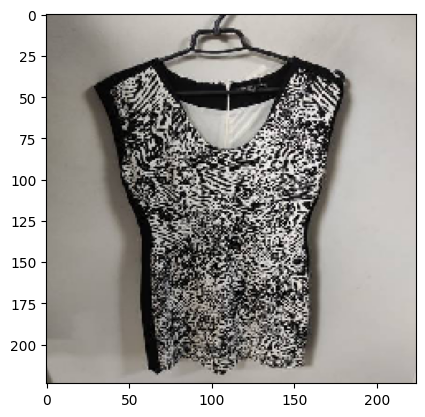

1/1 [==============================] - 0s 27ms/step
[[1.7140365e-04 1.1021766e-07 7.5258561e-07 6.4245975e-01 2.2809310e-05
  2.5188841e-04 5.6128914e-04 1.0053952e-08 3.9540683e-07 3.5232620e-03
  8.3980136e-05 3.6504916e-10 3.1749084e-07 3.3729773e-02 3.1919426e-01]]
{'Prediction': 'Dress'}


In [16]:
uploaded=files.upload()

label = ['Blazzer', 'Coat', 'Denim_Jacket', 'Dress', 'Gym_Jacket', 'Hoodie', 'Jacket', 'Jeans', 'Pants', 'Polo', 'Shirt (Kemeja)', 'Shorts', 'Skirt', 'Sweter', 'T-Shirt']

for fn in uploaded.keys():
 
  path = fn
  img=image.load_img(path, target_size=(224, 224))
  plt.imshow(img)
  plt.show()
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  pred_arr = my_model.predict(images, batch_size=5)
  predict = np.argmax(pred_arr, axis=1)
  
  print(pred_arr)
  data = {
      'Prediction' : label[predict[0]]}
  print(data)

# Color Recognition

Saving 1533.jpg to 1533 (3).jpg


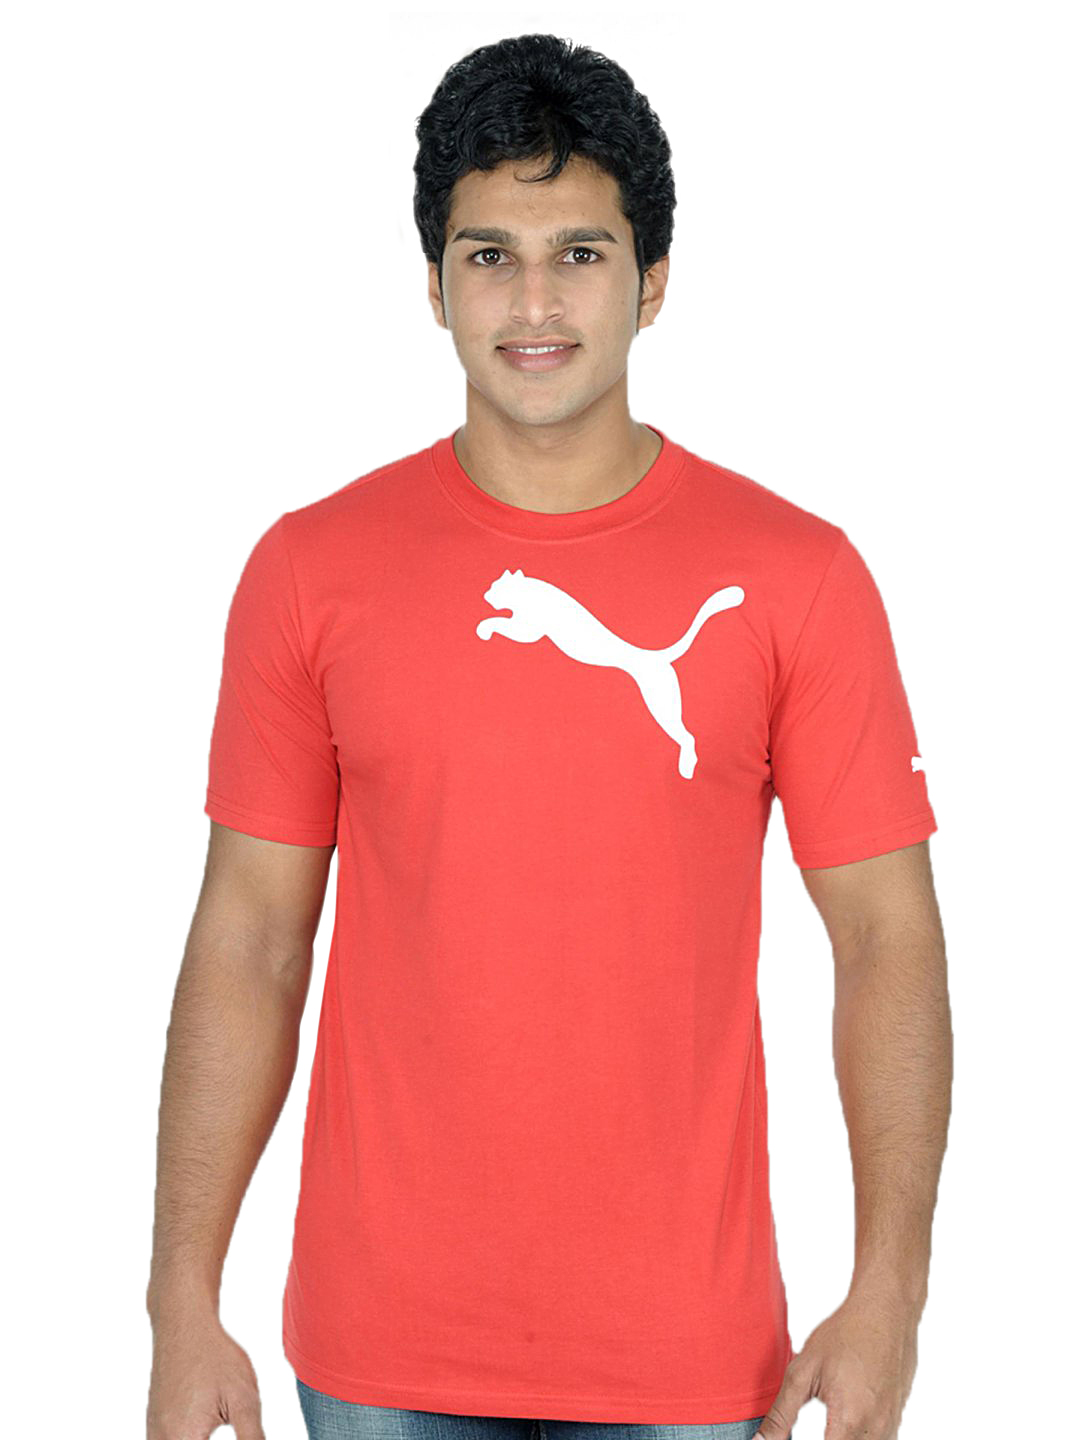

Color Category: Red
RGB Code: (255, 93, 90)


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
    img = cv2.imread(fn)

    height, width, _ = img.shape
    x = width // 2
    y = height // 2
    color_code = img[y, x]

    red, green, blue = color_code[::-1]

    if red < 50 and green < 50 and blue < 50:
        color = "Black"
    elif red > 200 and green > 200 and blue > 200:
        color = "White"
    else:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        height, width, _ = img.shape
        x = width // 2
        y = height // 2
        hue_value = hsv[y, x, 0]

        color = "Undefined"
        if hue_value < 5 or hue_value > 170:
            color = "Red"
        elif 5 <= hue_value < 22:
            color = "Orange"
        elif 22 <= hue_value < 33:
            color = "Yellow"
        elif 33 <= hue_value < 78:
            color = "Green"
        elif 78 <= hue_value < 131:
            color = "Blue"
        elif 131 <= hue_value < 170:
            color = "Violet"

    cv2_imshow(img)
    print("Color Category:", color)
    print("RGB Code:", (red, green, blue))
